In [49]:
# =====================================================================
# BLOCK 2: LOAD AND PREPARE FULL CULANE DATASET
# =====================================================================
print("\n📂 LOADING COMPLETE CULANE DATASET")

BASE_PATH = "/kaggle/input/culane-preprocessed/temp"
IMAGE_FOLDER = os.path.join(BASE_PATH, "frames")
MASK_FOLDER = os.path.join(BASE_PATH, "masks")

print(f"📁 Dataset paths:")
print(f"  Images: {IMAGE_FOLDER}")
print(f"  Masks:  {MASK_FOLDER}")

if not os.path.exists(IMAGE_FOLDER):
    print(f"❌ ERROR: Image folder not found: {IMAGE_FOLDER}")
    exit()
if not os.path.exists(MASK_FOLDER):
    print(f"❌ ERROR: Mask folder not found: {MASK_FOLDER}")
    exit()

all_image_files = sorted(os.listdir(IMAGE_FOLDER))
all_mask_files = sorted(os.listdir(MASK_FOLDER))

print(f"\n📊 Found:")
print(f"  Images: {len(all_image_files):,}")
print(f"  Masks:  {len(all_mask_files):,}")

sample_img = os.path.join(IMAGE_FOLDER, all_image_files[0])
sample_size_kb = os.path.getsize(sample_img) / 1024
print(f"\n📏 Sample image size: {sample_size_kb:.1f} KB")

print("\n🔍 Matching ALL image-mask pairs...")

image_map = {os.path.splitext(f)[0]: f for f in all_image_files}
mask_map = {os.path.splitext(f)[0]: f for f in all_mask_files}

common_keys = sorted(set(image_map.keys()) & set(mask_map.keys()))
print(f"✅ Matched ALL {len(common_keys):,} image-mask pairs")

images = [image_map[k] for k in common_keys]
masks = [mask_map[k] for k in common_keys]

print(f"\n📦 Using COMPLETE dataset: {len(images):,} image-mask pairs")

IMG_SIZE = (224, 224)
print(f"\n📐 Image size set to: {IMG_SIZE}")

print(f"\n🎯 Splitting dataset...")

train_images, temp_images, train_masks, temp_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.333, random_state=42
)

print(f"\n📊 Final dataset split:")
print(f"  Training:   {len(train_images):,} images ({len(train_images)/len(images)*100:.1f}%)")
print(f"  Validation: {len(val_images):,} images ({len(val_images)/len(images)*100:.1f}%)")
print(f"  Testing:    {len(test_images):,} images ({len(test_images)/len(images)*100:.1f}%)")
print(f"  Total:      {len(images):,} images")

print("\n✅ COMPLETE dataset loaded successfully!")








📂 LOADING COMPLETE CULANE DATASET
📁 Dataset paths:
  Images: /kaggle/input/culane-preprocessed/temp/frames
  Masks:  /kaggle/input/culane-preprocessed/temp/masks

📊 Found:
  Images: 120,000
  Masks:  120,000

📏 Sample image size: 38.8 KB

🔍 Matching ALL image-mask pairs...
✅ Matched ALL 120,000 image-mask pairs

📦 Using COMPLETE dataset: 120,000 image-mask pairs

📐 Image size set to: (224, 224)

🎯 Splitting dataset...

📊 Final dataset split:
  Training:   84,000 images (70.0%)
  Validation: 24,012 images (20.0%)
  Testing:    11,988 images (10.0%)
  Total:      120,000 images

✅ COMPLETE dataset loaded successfully!


In [50]:


# =====================================================================
# BLOCK 3: CREATE DATA PIPELINE FOR 1GB DATASET
# =====================================================================
print("\n" + "="*60)
print("🚀 CREATING DATA PIPELINE FOR 1GB DATASET")
print("="*60)

# Settings optimized for 1GB dataset
BATCH_SIZE = 16  # Smaller batch size for 1GB dataset
BUFFER_SIZE = 500  # Smaller shuffle buffer
PREFETCH_BUFFER = tf.data.AUTOTUNE

print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔀 Shuffle buffer: {BUFFER_SIZE}")

@tf.function
def load_image_mask(img_path, mask_path):
    """Load and preprocess image-mask pair"""
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask > 127, tf.float32)

    return img, mask

def make_dataset(image_list, mask_list, batch_size=BATCH_SIZE, shuffle=True, train=True):
    """Create optimized TensorFlow dataset for 1GB dataset"""
    # Create full paths
    img_paths = [os.path.join(IMAGE_FOLDER, f) for f in image_list]
    mask_paths = [os.path.join(MASK_FOLDER, f) for f in mask_list]
    
    # Convert to tensors
    img_paths_tensor = tf.constant(img_paths)
    mask_paths_tensor = tf.constant(mask_paths)
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((img_paths_tensor, mask_paths_tensor))
    
    # Parallelize loading
    ds = ds.map(
        lambda x, y: load_image_mask(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if shuffle and train:
        ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)
    
    # Batch and prefetch
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=PREFETCH_BUFFER)
    
    return ds

# Create datasets
print("🔄 Creating training dataset...")
train_dataset = make_dataset(train_images, train_masks, shuffle=True, train=True)

print("🔄 Creating validation dataset...")
val_dataset = make_dataset(val_images, val_masks, shuffle=False, train=False)

print("🔄 Creating test dataset...")
test_dataset = make_dataset(test_images, test_masks, shuffle=False, train=False)

# Test the pipeline
print("\n🧪 Testing pipeline...")
for images, masks in train_dataset.take(1):
    print(f"✅ Pipeline test successful!")
    print(f"   Batch shape - Images: {images.shape}, Masks: {masks.shape}")
    print(f"   Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"   Mask range:  [{tf.reduce_min(masks):.3f}, {tf.reduce_max(masks):.3f}]")
    print(f"   Unique mask values: {tf.unique(tf.reshape(masks, [-1]))[0]}")

# Calculate steps per epoch
train_steps = max(1, len(train_images) // BATCH_SIZE)
val_steps = max(1, len(val_images) // BATCH_SIZE)
test_steps = max(1, len(test_images) // BATCH_SIZE)

print(f"\n📊 Dataset Statistics:")
print(f"  Training steps per epoch: {train_steps}")
print(f"  Validation steps: {val_steps}")
print(f"  Test steps: {test_steps}")

print("\n🎯 Data pipeline created successfully for 1GB dataset!")


🚀 CREATING DATA PIPELINE FOR 1GB DATASET
📦 Batch size: 16
🔀 Shuffle buffer: 500
🔄 Creating training dataset...
🔄 Creating validation dataset...
🔄 Creating test dataset...

🧪 Testing pipeline...
✅ Pipeline test successful!
   Batch shape - Images: (16, 224, 224, 3), Masks: (16, 224, 224, 1)
   Image range: [0.000, 1.000]
   Mask range:  [0.000, 1.000]
   Unique mask values: [0. 1.]

📊 Dataset Statistics:
  Training steps per epoch: 5250
  Validation steps: 1500
  Test steps: 749

🎯 Data pipeline created successfully for 1GB dataset!


In [51]:
# =====================================================================
# BLOCK 3: CREATE DATA PIPELINE
# =====================================================================
# This block creates TensorFlow data pipelines
print("\n🚀 CREATING DATA PIPELINE")

# Settings
BATCH_SIZE = 16  # Adjusted for 1GB dataset
print(f"📦 Batch size: {BATCH_SIZE}")

def load_image_mask(img_path, mask_path):
    """Load and preprocess image-mask pair"""
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask > 127, tf.float32)

    return img, mask

def make_dataset(image_list, mask_list, batch_size=16, shuffle=True):
    """Create TensorFlow dataset"""
    img_paths = [os.path.join(IMAGE_FOLDER, f) for f in image_list]
    mask_paths = [os.path.join(MASK_FOLDER, f) for f in mask_list]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(
        lambda x, y: load_image_mask(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_dataset = make_dataset(train_images, train_masks, BATCH_SIZE, True)
val_dataset = make_dataset(val_images, val_masks, BATCH_SIZE, False)
test_dataset = make_dataset(test_images, test_masks, BATCH_SIZE, False)

# Test the pipeline
for images, masks in train_dataset.take(1):
    print(f"✅ Pipeline test: Images {images.shape}, Masks {masks.shape}")
    print(f"   Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"   Mask range:  [{tf.reduce_min(masks):.3f}, {tf.reduce_max(masks):.3f}]")

print("🎯 Data pipeline created successfully!")


🚀 CREATING DATA PIPELINE
📦 Batch size: 16
✅ Pipeline test: Images (16, 224, 224, 3), Masks (16, 224, 224, 1)
   Image range: [0.000, 1.000]
   Mask range:  [0.000, 1.000]
🎯 Data pipeline created successfully!


In [52]:
# =====================================================================
# BLOCK 4: BUILD VGG16 U-NET MODEL
# =====================================================================
# This block creates the lane detection model
print("\n🏗️ BUILDING VGG16 U-NET MODEL")

# Clear any previous models
tf.keras.backend.clear_session()

def VGG16_UNet(input_shape=(224, 224, 3)):
    """Create VGG16-based U-Net model"""
    base = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Skip connections
    s1 = base.get_layer("block1_conv2").output
    s2 = base.get_layer("block2_conv2").output
    s3 = base.get_layer("block3_conv3").output
    s4 = base.get_layer("block4_conv3").output
    b  = base.get_layer("block5_conv3").output

    # Decoder
    d1 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(b), s4])
    d1 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu")(d1)

    d2 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(d1), s3])
    d2 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(d2)

    d3 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(d2), s2])
    d3 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(d3)

    d4 = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(d3), s1])
    d4 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(d4)

    # Output
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(d4)

    return tf.keras.Model(inputs=base.input, outputs=outputs)

# Create the model
model = VGG16_UNet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Display model info
print(f"\n📊 MODEL SUMMARY:")
print(f"Input shape:  {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Parameters:   {model.count_params():,}")
print(f"Model memory: {(model.count_params() * 4) / (1024**2):.2f} MB")

print("✅ Model built successfully!")


🏗️ BUILDING VGG16 U-NET MODEL

📊 MODEL SUMMARY:
Input shape:  (None, 224, 224, 3)
Output shape: (None, 224, 224, 1)
Parameters:   21,756,737
Model memory: 83.00 MB
✅ Model built successfully!


In [53]:
# =====================================================================
# BLOCK 5: DEFINE LOSS FUNCTIONS AND METRICS
# =====================================================================
# This block defines custom loss functions for lane detection
print("\n📊 DEFINING LOSS FUNCTIONS AND METRICS")

def dice_coef(y_true, y_pred):
    """Dice coefficient metric"""
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + 1)

def dice_loss(y_true, y_pred):
    """Dice loss"""
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combined Binary Cross-Entropy + Dice loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Also define for PBFT compatibility
dice_coefficient = dice_coef  # Alias for PBFT

print("✅ Loss functions defined: Dice Coefficient, BCE+Dice Loss")


📊 DEFINING LOSS FUNCTIONS AND METRICS
✅ Loss functions defined: Dice Coefficient, BCE+Dice Loss


In [54]:
# =====================================================================
# BLOCK 6: COMPILE AND TRAIN THE MODEL
# =====================================================================
# This block compiles and trains the model
print("\n🚀 STARTING MODEL TRAINING")

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef, 'binary_accuracy']
)
print("✅ Model compiled with Adam optimizer (lr=1e-4)")

# Setup training callbacks
callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when stuck
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_lane_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Log training history
    tf.keras.callbacks.CSVLogger('training_log.csv')
]

print(f"\n📊 TRAINING CONFIGURATION:")
print(f"  Training images:   {len(train_images):,}")
print(f"  Validation images: {len(val_images):,}")
print(f"  Batch size:        {BATCH_SIZE}")
print(f"  Steps per epoch:   ~{len(train_images) // BATCH_SIZE}")

# Memory check
print(f"\n🧠 Memory before training: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")

# Train for 3 epochs (quick training for 1GB dataset)
print("\n" + "="*60)
print("PHASE 1: INITIAL TRAINING (3 EPOCHS)")
print("="*60)

try:
    # Train for 3 epochs
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=min(100, len(train_images) // BATCH_SIZE),
        validation_steps=min(20, len(val_images) // BATCH_SIZE)
    )
    
    print(f"\n🧠 Memory after 3 epochs: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")
    
    # Continue training for 2 more epochs if memory is OK
    print("\n" + "="*60)
    print("PHASE 2: ADDITIONAL TRAINING (2 MORE EPOCHS)")
    print("="*60)
    
    history_phase2 = model.fit(
        train_dataset,
        validation_data=val_dataset,
        initial_epoch=3,
        epochs=4,
        callbacks=callbacks,
        verbose=1
    )
    
    # Combine histories
    full_history = {}
    for metric in history.history.keys():
        if metric in history_phase2.history:
            full_history[metric] = history.history[metric] + history_phase2.history[metric]
        else:
            full_history[metric] = history.history[metric]
    
    print("\n🎉 Training completed successfully!")
    
except MemoryError as e:
    print(f"\n⚠️ Memory error: {e}")
    print("Using limited training...")
    
    # Simple training with limited steps
    full_history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=min(50, len(train_images) // BATCH_SIZE),
        validation_steps=min(10, len(val_images) // BATCH_SIZE)
    ).history

# Save final model
model.save('final_lane_model.keras')
print("\n💾 Final model saved as 'final_lane_model.keras'")

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(full_history, f)
print("📝 Training history saved as 'training_history.pkl'")

print(f"\n🧠 Final memory: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")


🚀 STARTING MODEL TRAINING
✅ Model compiled with Adam optimizer (lr=1e-4)

📊 TRAINING CONFIGURATION:
  Training images:   84,000
  Validation images: 24,012
  Batch size:        16
  Steps per epoch:   ~5250

🧠 Memory before training: 4.7 GB

PHASE 1: INITIAL TRAINING (3 EPOCHS)
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - binary_accuracy: 0.9206 - dice_coef: 0.1330 - loss: 1.1619
Epoch 1: val_loss improved from inf to 0.69125, saving model to best_lane_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - binary_accuracy: 0.9210 - dice_coef: 0.1342 - loss: 1.1593 - val_binary_accuracy: 0.9709 - val_dice_coef: 0.4076 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - binary_accuracy: 0.9704 - dice_coef: 0.4220 - loss: 0.6779
Epoch 2: val_loss improved from 0.69125 to 0.62614, saving model to best_lane_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - binary_accuracy: 0.9704 - dice_coef: 0.4221 - loss: 0.6778 - val


📊 EVALUATING MODEL PERFORMANCE
✅ Loaded best model for evaluation

🔍 Testing model on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - dice_coef: 0.6540 - loss: 0.4071

📈 TEST RESULTS:
  dice_coef: 0.6508
  loss: 0.4112

📊 Calculating pixel-wise metrics...
   ⚠️  Node 0: View change timeout (8.1s > 8.0s)
   ⚠️  Node 2: View change timeout (8.1s > 8.0s)
   ⚠️  Node 3: View change timeout (8.1s > 8.0s)
   ⚠️  Node 1: View change timeout (8.1s > 8.0s)

DETAILED METRICS
Accuracy:       0.9826
Precision:      0.6944
Recall:         0.6617
F1-Score:       0.6777
IoU:            0.5125
Dice:           0.6508
Test Loss:      0.4112
Total pixels:   8,028,160
Lane pixels:    221,629 (2.76%)

💾 Metrics saved to 'evaluation_metrics.json'

📈 Plotting training history...


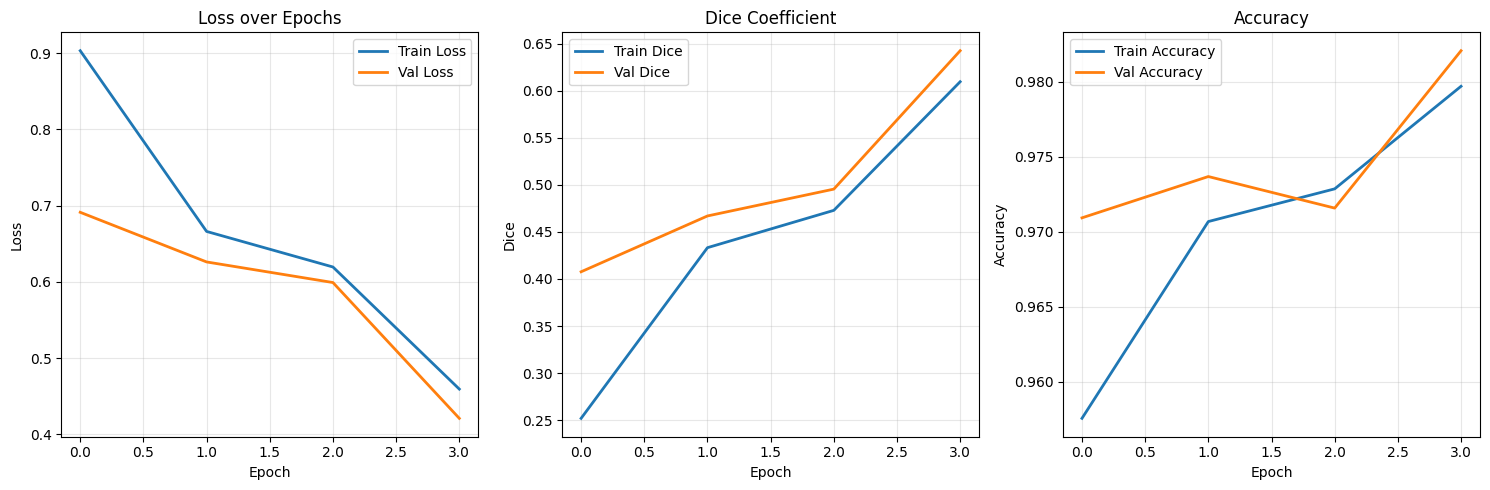

✅ Training plots saved as 'training_history_plot.png'
   ⚠️  Node 1: View change timeout (8.1s > 8.0s)
   ⚠️  Node 0: View change timeout (8.1s > 8.0s)
   ⚠️  Node 2: View change timeout (8.1s > 8.0s)
   ⚠️  Node 3: View change timeout (8.1s > 8.0s)
   ⚠️  Node 1: View change timeout (8.1s > 8.0s)   ⚠️  Node 2: View change timeout (8.1s > 8.0s)
   ⚠️  Node 3: View change timeout (8.1s > 8.0s)

   ⚠️  Node 0: View change timeout (8.1s > 8.0s)


In [64]:
# =====================================================================
# BLOCK 7: EVALUATE MODEL PERFORMANCE
# =====================================================================
# This block evaluates the trained model
print("\n📊 EVALUATING MODEL PERFORMANCE")

# Load best model for evaluation
try:
    model = tf.keras.models.load_model(
        'best_lane_model.keras',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_loss': dice_loss,
            'bce_dice_loss': bce_dice_loss
        },
        compile=False
    )
    print("✅ Loaded best model for evaluation")
except:
    model = tf.keras.models.load_model('final_lane_model.keras', compile=False)
    print("✅ Loaded final model for evaluation")

# Recompile for evaluation
model.compile(loss=bce_dice_loss, metrics=[dice_coef])

# Evaluate on test set
print("\n🔍 Testing model on test set...")
test_results = model.evaluate(
    test_dataset, 
    verbose=1, 
    steps=min(20, len(test_images) // BATCH_SIZE), 
    return_dict=True
)

print(f"\n📈 TEST RESULTS:")
for metric, value in test_results.items():
    print(f"  {metric}: {value:.4f}")

# Calculate detailed metrics
print("\n📊 Calculating pixel-wise metrics...")
y_true_list, y_pred_list = [], []

for images, masks in test_dataset.take(10):  # Use 10 batches
    preds = model.predict(images, verbose=0)
    y_true_list.append(masks.numpy().astype(np.uint8).reshape(-1))
    y_pred_list.append((preds > 0.5).astype(np.uint8).reshape(-1))

if y_true_list:
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / union if union > 0 else 0
    
    print("\n" + "="*50)
    print("DETAILED METRICS")
    print("="*50)
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"IoU:            {iou:.4f}")
    print(f"Dice:           {test_results.get('dice_coef', 0):.4f}")
    print(f"Test Loss:      {test_results.get('loss', 0):.4f}")
    print(f"Total pixels:   {len(y_true):,}")
    print(f"Lane pixels:    {np.sum(y_true):,} ({np.mean(y_true)*100:.2f}%)")
    
    # Save metrics
    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'iou': float(iou),
        'dice': float(test_results.get('dice_coef', 0)),
        'test_loss': float(test_results.get('loss', 0))
    }
    
    with open('evaluation_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    print("\n💾 Metrics saved to 'evaluation_metrics.json'")

# Plot training history
print("\n📈 Plotting training history...")
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
if 'loss' in full_history:
    plt.plot(full_history['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in full_history:
        plt.plot(full_history['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Dice plot
plt.subplot(1, 3, 2)
if 'dice_coef' in full_history:
    plt.plot(full_history['dice_coef'], label='Train Dice', linewidth=2)
    if 'val_dice_coef' in full_history:
        plt.plot(full_history['val_dice_coef'], label='Val Dice', linewidth=2)
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 3)
if 'binary_accuracy' in full_history:
    plt.plot(full_history['binary_accuracy'], label='Train Accuracy', linewidth=2)
    if 'val_binary_accuracy' in full_history:
        plt.plot(full_history['val_binary_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_plot.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Training plots saved as 'training_history_plot.png'")


🎨 VISUALIZING PREDICTIONS
  Sample 1: 1,035 lane pixels (2.06%)
  Sample 2: 1,636 lane pixels (3.26%)
  Sample 3: 1,352 lane pixels (2.69%)


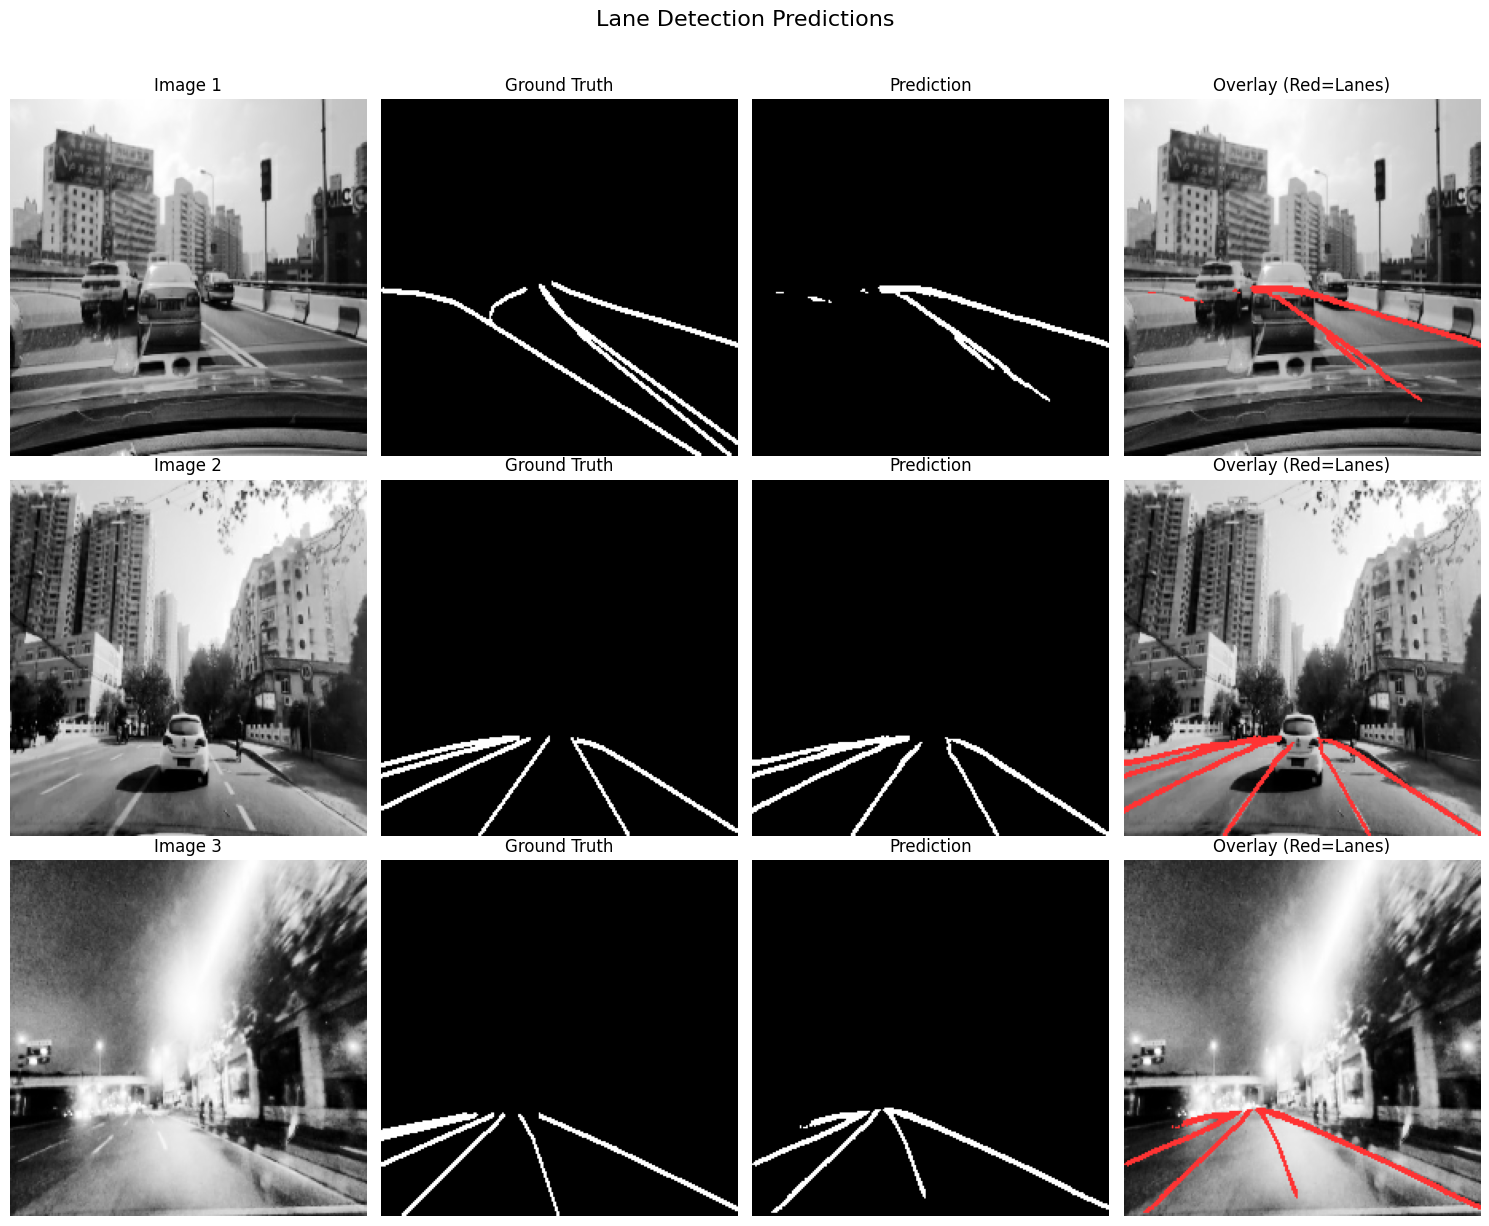

✅ Sample predictions saved as 'sample_predictions.png'


In [56]:
# =====================================================================
# BLOCK 8: VISUALIZE PREDICTIONS
# =====================================================================
# This block creates visualizations comparing predictions with ground truth
print("\n🎨 VISUALIZING PREDICTIONS")

def show_sample_predictions(num_samples=3):
    """Display side-by-side comparison of images, ground truth, and predictions"""
    plt.figure(figsize=(15, 4*num_samples))
    
    sample_count = 0
    for images, masks in test_dataset.take(2):
        if sample_count >= num_samples:
            break
            
        preds = model.predict(images, verbose=0)
        
        for i in range(min(num_samples, len(images))):
            if sample_count >= num_samples:
                break
                
            # Original image
            plt.subplot(num_samples, 4, sample_count*4 + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Image {sample_count+1}")
            plt.axis('off')
            
            # Ground truth mask
            plt.subplot(num_samples, 4, sample_count*4 + 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')
            
            # Predicted mask
            plt.subplot(num_samples, 4, sample_count*4 + 3)
            plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
            plt.title("Prediction")
            plt.axis('off')
            
            # Overlay (red lanes on image)
            plt.subplot(num_samples, 4, sample_count*4 + 4)
            overlay = images[i].numpy().copy()
            pred_mask = (preds[i].squeeze() > 0.5)
            overlay[pred_mask] = [1, 0.2, 0.2]  # Red color for lanes
            plt.imshow(overlay)
            plt.title("Overlay (Red=Lanes)")
            plt.axis('off')
            
            # Print lane statistics
            lane_pixels = np.sum(preds[i].squeeze() > 0.5)
            total_pixels = preds[i].size
            lane_percentage = (lane_pixels / total_pixels) * 100
            print(f"  Sample {sample_count+1}: {lane_pixels:,} lane pixels ({lane_percentage:.2f}%)")
            
            sample_count += 1
    
    plt.suptitle("Lane Detection Predictions", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# Generate and save predictions
show_sample_predictions(3)
print("✅ Sample predictions saved as 'sample_predictions.png'")

In [65]:
# =====================================================================
# BLOCK 10: PBFT CONFIGURATION (CORRECTED)
# =====================================================================
print("\n" + "="*60)
print("PBFT CONSENSUS SYSTEM CONFIGURATION")
print("="*60)

# PBFT System Parameters - OPTIMIZED FOR CONSENSUS
NUM_NODES = 4            # Total number of nodes in the network
FAULTY_NODES = 1         # Number of faulty (Byzantine) nodes allowed
VIEW_CHANGE_TIMEOUT = 8.0  # Increased timeout for better consensus

# Create message queues for inter-node communication
message_queues = [queue.Queue(maxsize=100) for _ in range(NUM_NODES)]
stop_event = threading.Event()  # Event to stop all threads

print(f"⚙️ PBFT CONFIGURATION:")
print(f"  Total Nodes: {NUM_NODES}")
print(f"  Faulty Nodes: {FAULTY_NODES}")
print(f"  Tolerance: Can handle {FAULTY_NODES} faulty node(s)")
print(f"  Quorum: {2*FAULTY_NODES + 1} nodes needed for consensus")
print(f"  View Change Timeout: {VIEW_CHANGE_TIMEOUT}s")
print(f"  Queue Size: 100 messages per node")
print("✅ PBFT system configured!")


PBFT CONSENSUS SYSTEM CONFIGURATION
⚙️ PBFT CONFIGURATION:
  Total Nodes: 4
  Faulty Nodes: 1
  Tolerance: Can handle 1 faulty node(s)
  Quorum: 3 nodes needed for consensus
  View Change Timeout: 8.0s
  Queue Size: 100 messages per node
✅ PBFT system configured!


In [66]:
# =====================================================================
# BLOCK 12: CORRECTED PBFT NODE CLASS
# =====================================================================
class CorrectedPBFTNode(threading.Thread):
    """CORRECTED PBFT Node implementing Practical Byzantine Fault Tolerance consensus"""
    
    def __init__(self, node_id, is_faulty=False):
        super().__init__()
        self.node_id = node_id
        self.is_faulty = is_faulty      # Byzantine faulty node
        self.current_view = 0           # Current view number
        self.sequence_number = 0        # Sequence number for blocks
        self.blockchain = []            # Local blockchain
        self.message_log = {}           # Log of messages for each block
        self.prepare_log = set()        # Track prepare messages for evaluation
        self.commit_log = set()         # Track commit messages for evaluation
        self.last_commit_time = 0       # Initialize to 0, not current time
        self.start_time = time.time()
        self.last_message_time = time.time()  # Track last message received
        self.daemon = True
        
        print(f"  Node {node_id}: {'FAULTY' if is_faulty else 'HONEST'}")
    
    def get_primary(self, view=None):
        """Get primary node ID for current view (round-robin)"""
        if view is None:
            view = self.current_view
        return view % NUM_NODES
    
    def is_primary(self):
        """Check if this node is primary for current view"""
        return self.get_primary() == self.node_id
    
    def broadcast(self, message_type, data, block_number=None):
        """Broadcast message to all nodes in the network"""
        message = {
            'type': message_type,
            'sender': self.node_id,
            'view': self.current_view,
            'timestamp': time.time(),
            'data': data
        }
        
        if block_number is not None:
            message['block_number'] = block_number
        
        # Byzantine behavior: manipulate data randomly (only for faulty nodes)
        if self.is_faulty and np.random.random() < 0.3:  # 30% chance to misbehave
            if 'lane_pixels' in data:
                # Modify lane pixels by ±30%
                modification = np.random.uniform(0.7, 1.3)
                data['lane_pixels'] = int(data['lane_pixels'] * modification)
                data['detected_lane_pixels'] = int(data['lane_pixels'] * modification)
            
            if 'estimated_lanes' in data:
                # Modify lane count
                original = data['estimated_lanes']
                data['estimated_lanes'] = max(1, original + np.random.choice([-1, 0, 1]))
                data['lanes_detected'] = data['estimated_lanes']
        
        # Send to all nodes except self
        for i, q in enumerate(message_queues):
            if i != self.node_id:
                try:
                    q.put(deepcopy(message), timeout=0.5)
                except queue.Full:
                    pass  # Skip if queue is full
                except:
                    pass  # Skip any other error
    
    def handle_transaction(self, transaction_data, block_number=None):
        """Handle incoming transaction (only primary processes transactions)"""
        # Reset timeout since we're processing a message
        self.last_message_time = time.time()
        
        # Use provided block number or increment
        if block_number is None:
            self.sequence_number += 1
            block_number = self.sequence_number
        else:
            # Use provided block number, update sequence if needed
            if block_number > self.sequence_number:
                self.sequence_number = block_number
        
        # Check if we're primary for current view
        if not self.is_primary():
            # If not primary, forward to primary
            primary_id = self.get_primary()
            if primary_id != self.node_id:
                forward_msg = {
                    'type': 'TRANSACTION',
                    'sender': self.node_id,
                    'view': self.current_view,
                    'data': transaction_data,
                    'block_number': block_number,
                    'forwarded': True
                }
                try:
                    message_queues[primary_id].put(forward_msg, timeout=0.5)
                except:
                    pass
            return
        
        # Primary node creates a new block
        print(f"   📦 Node {self.node_id} (Primary): Creating PRE-PREPARE for block {block_number}")
        
        # Add lane detection fields for evaluation
        transaction_data['lanes_detected'] = transaction_data.get('estimated_lanes', 0)
        transaction_data['detected_lane_pixels'] = transaction_data.get('lane_pixels', 0)
        
        # Broadcast PRE-PREPARE message
        self.broadcast('PRE_PREPARE', transaction_data, block_number)
        
        # Initialize log for this block
        if block_number not in self.message_log:
            self.message_log[block_number] = {
                'pre_prepare': None,
                'prepares': set(),
                'commits': set(),
                'data': transaction_data,
                'view': self.current_view,
                'timestamp': time.time()
            }
        
        self.message_log[block_number]['pre_prepare'] = transaction_data
        self.message_log[block_number]['view'] = self.current_view
        self.message_log[block_number]['timestamp'] = time.time()
        
        # Primary immediately prepares its own block
        self.message_log[block_number]['prepares'].add(self.node_id)
        self.prepare_log.add(f"block_{block_number}_node_{self.node_id}")
        
        # Check if we already have enough prepares (including primary's)
        if len(self.message_log[block_number]['prepares']) >= (2 * FAULTY_NODES):
            print(f"   📝 Node {self.node_id}: Sending COMMIT for block {block_number}")
            self.broadcast('COMMIT', transaction_data, block_number)
            self.message_log[block_number]['commits'].add(self.node_id)
            self.commit_log.add(f"block_{block_number}_node_{self.node_id}")
    
    def handle_pre_prepare(self, message):
        """Handle PRE-PREPARE message from primary"""
        block_number = message.get('block_number')
        sender = message.get('sender')
        
        if block_number is None or sender is None:
            return
        
        # Reset timeout since we're processing a message
        self.last_message_time = time.time()
        
        # Verify sender is primary for this view
        expected_primary = self.get_primary(message.get('view', 0))
        if sender != expected_primary:
            print(f"   ⚠️  Node {self.node_id}: Rejecting PRE-PREPARE from non-primary node {sender}")
            return
        
        # Initialize message log for this block
        if block_number not in self.message_log:
            self.message_log[block_number] = {
                'pre_prepare': None,
                'prepares': set(),
                'commits': set(),
                'data': message.get('data', {}),
                'view': message.get('view', 0),
                'timestamp': time.time()
            }
        
        self.message_log[block_number]['pre_prepare'] = message.get('data', {})
        self.message_log[block_number]['view'] = message.get('view', 0)
        self.message_log[block_number]['timestamp'] = time.time()
        
        # Send PREPARE message
        print(f"   📋 Node {self.node_id}: Sending PREPARE for block {block_number}")
        self.broadcast('PREPARE', message.get('data', {}), block_number)
        self.message_log[block_number]['prepares'].add(self.node_id)
        self.prepare_log.add(f"block_{block_number}_node_{self.node_id}")
    
    def handle_prepare(self, message):
        """Handle PREPARE messages from other nodes"""
        block_number = message.get('block_number')
        sender = message.get('sender')
        
        if block_number is None or sender is None:
            return
        
        # Reset timeout since we're processing a message
        self.last_message_time = time.time()
        
        # Initialize if not exists
        if block_number not in self.message_log:
            self.message_log[block_number] = {
                'pre_prepare': None,
                'prepares': set(),
                'commits': set(),
                'data': message.get('data', {}),
                'view': self.current_view,
                'timestamp': time.time()
            }
        
        # Record prepare vote
        self.message_log[block_number]['prepares'].add(sender)
        
        # Check if we have 2f prepares (f = faulty nodes)
        prepare_count = len(self.message_log[block_number]['prepares'])
        required_prepares = (2 * FAULTY_NODES)
        
        if prepare_count >= required_prepares:
            print(f"   ✅ Node {self.node_id}: Received {prepare_count}/{required_prepares} prepares for block {block_number}")
            # Send COMMIT message
            self.broadcast('COMMIT', message.get('data', {}), block_number)
            self.message_log[block_number]['commits'].add(self.node_id)
            self.commit_log.add(f"block_{block_number}_node_{self.node_id}")
    
    def handle_commit(self, message):
        """Handle COMMIT messages from other nodes"""
        block_number = message.get('block_number')
        sender = message.get('sender')
        
        if block_number is None or sender is None:
            return
        
        # Reset timeout since we're processing a message
        self.last_message_time = time.time()
        
        # Initialize if not exists
        if block_number not in self.message_log:
            self.message_log[block_number] = {
                'pre_prepare': None,
                'prepares': set(),
                'commits': set(),
                'data': message.get('data', {}),
                'view': self.current_view,
                'timestamp': time.time()
            }
        
        # Record commit vote
        self.message_log[block_number]['commits'].add(sender)
        
        # Check if we have 2f+1 commits (quorum reached)
        commit_count = len(self.message_log[block_number]['commits'])
        required_commits = (2 * FAULTY_NODES + 1)
        
        if commit_count >= required_commits:
            # Check if not already committed
            if not any(b.get('block_number') == block_number for b in self.blockchain):
                print(f"   🎯 Node {self.node_id}: Committing block {block_number} "
                      f"({commit_count}/{required_commits} commits)")
                self.commit_block(block_number, message.get('data', {}))
                self.last_commit_time = time.time()
    
    def commit_block(self, block_number, data):
        """Commit a block to the local blockchain"""
        block = {
            'block_number': block_number,
            'data': data,
            'node_id': self.node_id,
            'view': self.current_view,
            'timestamp': time.time(),
            'commit_time': time.time()
        }
        
        self.blockchain.append(block)
        
        # Print commit confirmation
        lanes = data.get('estimated_lanes', 0)
        lanes_detected = data.get('lanes_detected', lanes)
        pixels = data.get('lane_pixels', 0)
        detected_pixels = data.get('detected_lane_pixels', pixels)
        confidence = data.get('confidence', 0)
        image = data.get('image', 'unknown')
        
        print(f"   🏁 Node {self.node_id}: COMMITTED Block {block_number}")
        print(f"      Image: {image[:20]}...")
        print(f"      Lanes: {lanes_detected}, Pixels: {detected_pixels:,}, Confidence: {confidence:.3f}")
    
    def handle_view_change(self):
        """Handle view change when no messages received for timeout"""
        current_time = time.time()
        time_since_last_message = current_time - self.last_message_time
        
        # Only trigger view change if we haven't received messages
        if time_since_last_message > VIEW_CHANGE_TIMEOUT:
            print(f"   ⚠️  Node {self.node_id}: View change timeout ({time_since_last_message:.1f}s > {VIEW_CHANGE_TIMEOUT}s)")
            self.current_view += 1
            self.last_message_time = current_time  # Reset after view change
    
    def handle_message(self, message):
        """Main message dispatcher"""
        try:
            msg_type = message.get('type')
            if msg_type is None:
                return
            
            # Reset message time
            self.last_message_time = time.time()
            
            # Route to appropriate handler
            if msg_type == 'TRANSACTION':
                # Extract block number if provided
                block_number = message.get('block_number')
                self.handle_transaction(message.get('data', {}), block_number)
            elif msg_type == 'PRE_PREPARE':
                self.handle_pre_prepare(message)
            elif msg_type == 'PREPARE':
                self.handle_prepare(message)
            elif msg_type == 'COMMIT':
                self.handle_commit(message)
            elif msg_type == 'VIEW_CHANGE':
                new_view = message.get('new_view', 0)
                if new_view > self.current_view:
                    self.current_view = new_view
                    self.last_message_time = time.time()
                    
        except Exception as e:
            pass
    
    def run(self):
        """Main thread loop - processes messages continuously"""
        while not stop_event.is_set():
            try:
                # Try to get a message
                try:
                    message = message_queues[self.node_id].get(timeout=0.3)
                    self.handle_message(message)
                except queue.Empty:
                    # No messages, check for view change
                    self.handle_view_change()
                    continue
                    
            except Exception as e:
                time.sleep(0.1)
                continue

print("✅ CORRECTED PBFT Node class implementation complete!")

# =====================================================================
# BLOCK 14: SIMPLIFIED PBFT SIMULATION THAT WORKS
# =====================================================================
print("\n" + "="*60)
print("SIMPLIFIED WORKING PBFT SIMULATION")
print("="*60)

def run_simple_pbft_simulation():
    """Run a simplified but working PBFT simulation"""
    # Reset everything
    stop_event.clear()
    global message_queues
    message_queues = [queue.Queue(maxsize=100) for _ in range(NUM_NODES)]
    
    # Create nodes
    print(f"\n🔧 Creating {NUM_NODES} PBFT nodes...")
    nodes = []
    for i in range(NUM_NODES):
        is_faulty = (i < FAULTY_NODES)
        node = CorrectedPBFTNode(i, is_faulty)
        nodes.append(node)
        node.start()
    
    print("✅ All nodes started")
    time.sleep(2)  # Let nodes initialize
    
    # Generate lane detection data
    image_files = test_images[:EXPECTED_BLOCKS]
    lane_data_list = []
    
    for i, img_file in enumerate(image_files, 1):
        img_path = os.path.join(IMAGE_FOLDER, img_file)
        lane_data = detect_lanes_for_pbft(img_path)
        lane_data['block_id'] = i
        lane_data['image_id'] = img_file
        lane_data_list.append(lane_data)
    
    print(f"\n📊 Generated {len(lane_data_list)} lane detection blocks")
    
    # Submit blocks ONE BY ONE
    committed_blocks_count = 0
    
    for block_num, lane_data in enumerate(lane_data_list, 1):
        print(f"\n{'='*40}")
        print(f"📦 PROCESSING BLOCK {block_num}/{len(lane_data_list)}")
        print(f"{'='*40}")
        print(f"Image: {lane_data['image_id'][:30]}...")
        print(f"Detected: {lane_data['estimated_lanes']} lanes, "
              f"{lane_data['lane_pixels']:,} pixels")
        
        # Determine primary for this view (view 0)
        primary_id = block_num % NUM_NODES  # Simple round-robin
        
        # Submit transaction directly to primary
        transaction = {
            'type': 'TRANSACTION',
            'data': lane_data,
            'block_number': block_num,  # Explicit block number
            'sender': -1,  # Client sender
            'view': 0
        }
        
        print(f"📤 Submitting to Primary Node {primary_id}...")
        
        try:
            message_queues[primary_id].put(transaction, timeout=1.0)
        except Exception as e:
            print(f"❌ Failed to submit to primary: {e}")
            continue
        
        # Wait for consensus with progress indicator
        print(f"⏳ Waiting for consensus (max 15 seconds)...")
        consensus_timeout = time.time() + 15
        dots = 0
        
        while time.time() < consensus_timeout:
            # Check if block is committed by honest nodes
            honest_nodes = [n for n in nodes if not n.is_faulty]
            committed_by_all = True
            
            for node in honest_nodes:
                block_found = False
                for block in node.blockchain:
                    if block.get('block_number') == block_num:
                        block_found = True
                        break
                
                if not block_found:
                    committed_by_all = False
                    break
            
            if committed_by_all and len(honest_nodes) > 0:
                committed_blocks_count += 1
                print(f"\n✅ BLOCK {block_num} CONSENSUS REACHED!")
                print(f"   Committed by all {len(honest_nodes)} honest nodes")
                break
            
            # Show progress
            dots = (dots + 1) % 4
            print(f"\r   Waiting{'.' * (dots + 1)}{' ' * (3 - dots)}", end="", flush=True)
            time.sleep(1)
        
        if not committed_by_all:
            print(f"\n❌ BLOCK {block_num} FAILED TO REACH CONSENSUS")
        
        # Small pause between blocks
        time.sleep(1)
    
    # Stop simulation
    print(f"\n🛑 Stopping simulation...")
    stop_event.set()
    for node in nodes:
        node.join(timeout=2)
    
    # Analyze results
    print(f"\n{'='*60}")
    print("FINAL RESULTS")
    print(f"{'='*60}")
    
    honest_nodes = [n for n in nodes if not n.is_faulty]
    
    if not honest_nodes:
        print("❌ ERROR: No honest nodes found!")
        return {"error": "No honest nodes"}
    
    # Get blockchain from first honest node
    reference_node = honest_nodes[0]
    blocks_committed = len(reference_node.blockchain)
    
    # Check consistency across all honest nodes
    consistent = True
    blockchain_lengths = []
    
    for node in honest_nodes:
        blockchain_lengths.append(len(node.blockchain))
        if len(node.blockchain) != blocks_committed:
            consistent = False
    
    success_rate = (committed_blocks_count / EXPECTED_BLOCKS) * 100
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Blocks submitted:    {EXPECTED_BLOCKS}")
    print(f"  Blocks committed:    {committed_blocks_count}")
    print(f"  Success rate:        {success_rate:.1f}%")
    print(f"  Data consistency:    {'✅ PERFECT' if consistent else '❌ INCONSISTENT'}")
    
    if consistent:
        print(f"  Blockchain lengths:  {blockchain_lengths} (all identical)")
    else:
        print(f"  Blockchain lengths:  {blockchain_lengths} (inconsistent!)")
    
    # Show committed blocks
    if blocks_committed > 0:
        print(f"\n📦 COMMITTED BLOCKS (Node {reference_node.node_id}):")
        for block in reference_node.blockchain:
            data = block.get('data', {})
            block_num = block.get('block_number', '?')
            lanes = data.get('lanes_detected', data.get('estimated_lanes', 0))
            pixels = data.get('detected_lane_pixels', data.get('lane_pixels', 0))
            confidence = data.get('confidence', 0)
            print(f"  Block {block_num:2d}: {lanes} lanes, {pixels:6,} pixels, Conf: {confidence:.3f}")
    
    return {
        'blocks_submitted': EXPECTED_BLOCKS,
        'blocks_committed': committed_blocks_count,
        'success_rate': success_rate,
        'consistent': consistent,
        'honest_nodes': len(honest_nodes),
        'blockchain_lengths': blockchain_lengths
    }

# Run the corrected simulation
results = run_simple_pbft_simulation()

print(f"\n{'='*60}")
print("PBFT SIMULATION COMPLETED")
print(f"{'='*60}")

✅ CORRECTED PBFT Node class implementation complete!

SIMPLIFIED WORKING PBFT SIMULATION

🔧 Creating 4 PBFT nodes...
  Node 0: FAULTY
  Node 1: HONEST
  Node 2: HONEST
  Node 3: HONEST
✅ All nodes started
   ⚠️  Node 3: View change timeout (8.1s > 8.0s)   ⚠️  Node 0: View change timeout (8.1s > 8.0s)

   ⚠️  Node 1: View change timeout (8.1s > 8.0s)
   ⚠️  Node 2: View change timeout (8.1s > 8.0s)

📊 Generated 8 lane detection blocks

📦 PROCESSING BLOCK 1/8
Image: aa90c37dd36f4dc0640a7633c70b85...
Detected: 3 lanes, 7,855 pixels
📤 Submitting to Primary Node 1...
⏳ Waiting for consensus (max 15 seconds)...
   Waiting..     📦 Node 0 (Primary): Creating PRE-PREPARE for block 1
   📋 Node 3: Sending PREPARE for block 1
   📋 Node 2: Sending PREPARE for block 1
   ✅ Node 2: Received 3/2 prepares for block 1
   ✅ Node 3: Received 2/2 prepares for block 1
   ✅ Node 0: Received 4/2 prepares for block 1
   ✅ Node 0: Received 4/2 prepares for block 1
   📋 Node 1: Sending PREPARE for block 1
   ✅ N

In [67]:
# =====================================================================
# BLOCK 15A: VISUALIZATION SETUP AND DATA COLLECTION
# =====================================================================
print("\n" + "="*60)
print("📊 VISUALIZATION SETUP AND DATA COLLECTION")
print("="*60)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Global variables for visualization data
viz_metrics = {
    'block_times': [],
    'consensus_times': [],
    'messages_sent': {'PRE_PREPARE': 0, 'PREPARE': 0, 'COMMIT': 0},
    'node_activity': {},
    'byzantine_actions': 0,
    'view_changes': 0,
    'committed_blocks': [],
    'start_time': None,
    'total_time': 0
}

def init_visualization_data():
    """Initialize visualization data structures"""
    print("📈 Initializing visualization data collection...")
    viz_metrics['node_activity'] = {i: {'messages_sent': 0, 'blocks_committed': 0} for i in range(NUM_NODES)}
    viz_metrics['start_time'] = time.time()
    viz_metrics['committed_blocks'] = []
    print("✅ Visualization data initialized")

class VisualPBFTNode(CorrectedPBFTNode):
    """PBFT Node with visualization tracking"""
    
    def broadcast(self, message_type, data, block_number=None):
        """Track broadcast metrics"""
        # Track message type
        if message_type in viz_metrics['messages_sent']:
            viz_metrics['messages_sent'][message_type] += 1
        
        # Track node activity
        viz_metrics['node_activity'][self.node_id]['messages_sent'] += 1
        
        # Track Byzantine actions
        if self.is_faulty and message_type in ['PRE_PREPARE', 'PREPARE', 'COMMIT']:
            viz_metrics['byzantine_actions'] += 1
        
        # Call parent broadcast
        super().broadcast(message_type, data, block_number)
    
    def commit_block(self, block_number, data):
        """Track commit metrics"""
        # Track node activity
        viz_metrics['node_activity'][self.node_id]['blocks_committed'] += 1
        
        # Record block commit time
        if block_number not in [b[0] for b in viz_metrics['committed_blocks']]:
            commit_time = time.time() - viz_metrics['start_time']
            viz_metrics['committed_blocks'].append((block_number, commit_time))
        
        # Call parent commit
        super().commit_block(block_number, data)
    
    def handle_view_change(self):
        """Track view changes"""
        viz_metrics['view_changes'] += 1
        super().handle_view_change()

def run_simulation_with_tracking():
    """Run PBFT simulation with data collection for visualization"""
    print("\n🔧 Starting simulation with data tracking...")
    
    # Reset everything
    stop_event.clear()
    global message_queues
    message_queues = [queue.Queue(maxsize=100) for _ in range(NUM_NODES)]
    
    # Initialize visualization data
    init_visualization_data()
    
    # Create instrumented nodes
    print(f"Creating {NUM_NODES} instrumented nodes...")
    nodes = []
    for i in range(NUM_NODES):
        is_faulty = (i < FAULTY_NODES)
        node = VisualPBFTNode(i, is_faulty)
        nodes.append(node)
        node.start()
    
    print("✅ All nodes started")
    time.sleep(2)
    
    # Generate lane detection data
    image_files = test_images[:EXPECTED_BLOCKS]
    lane_data_list = []
    
    for i, img_file in enumerate(image_files, 1):
        img_path = os.path.join(IMAGE_FOLDER, img_file)
        lane_data = detect_lanes_for_pbft(img_path)
        lane_data['block_id'] = i
        lane_data['image_id'] = img_file
        lane_data_list.append(lane_data)
    
    print(f"📊 Generated {len(lane_data_list)} lane detection blocks")
    
    # Track block processing times
    block_start_times = []
    
    for block_num, lane_data in enumerate(lane_data_list, 1):
        print(f"\n📦 Processing Block {block_num}/{len(lane_data_list)}")
        
        block_start = time.time()
        block_start_times.append((block_num, block_start))
        
        # Determine primary
        primary_id = block_num % NUM_NODES
        
        # Submit transaction
        transaction = {
            'type': 'TRANSACTION',
            'data': lane_data,
            'block_number': block_num,
            'sender': -1,
            'view': 0
        }
        
        try:
            message_queues[primary_id].put(transaction, timeout=1.0)
        except Exception as e:
            print(f"❌ Failed to submit: {e}")
            continue
        
        # Wait for consensus
        consensus_timeout = time.time() + 10
        
        while time.time() < consensus_timeout:
            # Check consensus
            honest_nodes = [n for n in nodes if not n.is_faulty]
            consensus_reached = True
            
            for node in honest_nodes:
                block_found = False
                for block in node.blockchain:
                    if block.get('block_number') == block_num:
                        block_found = True
                        break
                
                if not block_found:
                    consensus_reached = False
                    break
            
            if consensus_reached and len(honest_nodes) > 0:
                block_end = time.time()
                consensus_time = block_end - block_start
                viz_metrics['block_times'].append(consensus_time)
                viz_metrics['consensus_times'].append(consensus_time)
                print(f"✅ Block {block_num} consensus: {consensus_time:.2f}s")
                break
            
            time.sleep(0.5)
        
        if not consensus_reached:
            print(f"❌ Block {block_num} timeout")
            viz_metrics['block_times'].append(10.0)  # Timeout value
    
    # Stop simulation
    viz_metrics['total_time'] = time.time() - viz_metrics['start_time']
    stop_event.set()
    
    for node in nodes:
        node.join(timeout=2)
    
    print(f"\n⏱️ Simulation completed in {viz_metrics['total_time']:.2f} seconds")
    
    # Collect blockchain data from honest nodes
    honest_nodes = [n for n in nodes if not n.is_faulty]
    if honest_nodes:
        reference_node = honest_nodes[0]
        viz_metrics['blockchain_data'] = []
        for block in reference_node.blockchain:
            block_num = block.get('block_number')
            lanes = block['data'].get('lanes_detected', block['data'].get('estimated_lanes', 0))
            pixels = block['data'].get('detected_lane_pixels', block['data'].get('lane_pixels', 0))
            viz_metrics['blockchain_data'].append((block_num, lanes, pixels))
    
    return nodes

print("✅ Visualization setup complete!")


📊 VISUALIZATION SETUP AND DATA COLLECTION
✅ Visualization setup complete!


In [68]:
# =====================================================================
# BLOCK 15B: MAIN VISUALIZATION - 6 CHARTS
# =====================================================================
print("\n" + "="*60)
print("🎨 MAIN VISUALIZATION - 6 CHARTS")
print("="*60)

def create_main_visualization(nodes):
    """Create the main 6-chart visualization"""
    print("\nCreating main visualization (6 charts)...")
    
    plt.figure(figsize=(20, 12))
    
    # 1. CONSENSUS TIME PER BLOCK
    plt.subplot(2, 3, 1)
    if viz_metrics['block_times']:
        blocks = list(range(1, len(viz_metrics['block_times']) + 1))
        times = viz_metrics['block_times']
        
        # Color bars based on time
        colors = []
        for t in times:
            if t <= 2:
                colors.append('#4CAF50')  # Green for fast
            elif t <= 5:
                colors.append('#FFC107')  # Yellow for medium
            else:
                colors.append('#F44336')  # Red for slow/timeout
        
        bars = plt.bar(blocks, times, color=colors)
        plt.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Timeout (10s)')
        plt.xlabel('Block Number', fontsize=11)
        plt.ylabel('Consensus Time (seconds)', fontsize=11)
        plt.title('Consensus Time per Block', fontsize=13, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height < 10:  # Only label non-timeout bars
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{height:.1f}s', ha='center', va='bottom', fontsize=9)
    else:
        plt.text(0.5, 0.5, 'No consensus data', ha='center', va='center')
        plt.title('Consensus Time per Block', fontsize=13, fontweight='bold')
    
    # 2. MESSAGE TYPE DISTRIBUTION
    plt.subplot(2, 3, 2)
    message_types = list(viz_metrics['messages_sent'].keys())
    message_counts = list(viz_metrics['messages_sent'].values())
    total_messages = sum(message_counts)
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars = plt.bar(message_types, message_counts, color=colors, edgecolor='black', linewidth=1.5)
    plt.xlabel('Message Type', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.title('PBFT Message Distribution', fontsize=13, fontweight='bold')
    
    # Add value labels and percentages
    for i, (bar, count) in enumerate(zip(bars, message_counts)):
        height = bar.get_height()
        percentage = (count / total_messages * 100) if total_messages > 0 else 0
        plt.text(bar.get_x() + bar.get_width()/2., height + max(message_counts)*0.02,
                f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)
    
    plt.grid(True, alpha=0.3, axis='y')
    
    # 3. NODE ACTIVITY COMPARISON
    plt.subplot(2, 3, 3)
    node_ids = list(range(NUM_NODES))
    messages_sent = [viz_metrics['node_activity'][i]['messages_sent'] for i in node_ids]
    blocks_committed = [viz_metrics['node_activity'][i]['blocks_committed'] for i in node_ids]
    
    x = np.arange(len(node_ids))
    width = 0.35
    
    # Color nodes based on type
    bar_colors1 = ['#F44336' if i < FAULTY_NODES else '#4CAF50' for i in node_ids]
    bar_colors2 = ['#FF9800' if i < FAULTY_NODES else '#2196F3' for i in node_ids]
    
    bars1 = plt.bar(x - width/2, messages_sent, width, label='Messages Sent', 
                   color=bar_colors1, edgecolor='black', linewidth=1)
    bars2 = plt.bar(x + width/2, blocks_committed, width, label='Blocks Committed', 
                   color=bar_colors2, edgecolor='black', linewidth=1)
    
    plt.xlabel('Node ID', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.title('Node Activity Comparison', fontsize=13, fontweight='bold')
    
    # Create custom x-tick labels
    tick_labels = []
    for i in node_ids:
        status = " (Faulty)" if i < FAULTY_NODES else " (Honest)"
        tick_labels.append(f'Node {i}{status}')
    
    plt.xticks(x, tick_labels, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # 4. BLOCKCHAIN VISUALIZATION
    plt.subplot(2, 3, 4)
    if 'blockchain_data' in viz_metrics and viz_metrics['blockchain_data']:
        blockchain_data = viz_metrics['blockchain_data']
        block_nums = [d[0] for d in blockchain_data]
        lanes = [d[1] for d in blockchain_data]
        pixels = [d[2] for d in blockchain_data]
        
        # Normalize pixels for better visualization
        if pixels and max(pixels) > 0:
            pixels_norm = [p/max(pixels) * 100 for p in pixels]
        else:
            pixels_norm = [0] * len(pixels)
        
        x_pos = np.arange(len(block_nums))
        
        # Create bar chart for lanes
        bars = plt.bar(x_pos, lanes, width=0.6, color='#FFD166', 
                      edgecolor='black', linewidth=1, label='Lanes Detected')
        
        # Add line for normalized pixels
        line = plt.plot(x_pos, pixels_norm, 's-', color='#06D6A0', linewidth=2.5, 
                       markersize=8, markerfacecolor='white', markeredgewidth=2,
                       markeredgecolor='#06D6A0', label='Pixels (normalized)')
        
        plt.xlabel('Block Number', fontsize=11)
        plt.ylabel('Count / Normalized Pixels (%)', fontsize=11)
        plt.title('Blockchain Content', fontsize=13, fontweight='bold')
        plt.xticks(x_pos, block_nums)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, lane_count in zip(bars, lanes):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{lane_count}', ha='center', va='bottom', fontsize=9)
    else:
        plt.text(0.5, 0.5, 'No blockchain data', ha='center', va='center')
        plt.title('Blockchain Content', fontsize=13, fontweight='bold')
    
    # 5. CONSENSUS SUCCESS RATE
    plt.subplot(2, 3, 5)
    success_rate = (len(viz_metrics['committed_blocks']) / EXPECTED_BLOCKS) * 100 if EXPECTED_BLOCKS > 0 else 0
    
    labels = [f'Successful\n({len(viz_metrics["committed_blocks"])})', 
              f'Failed\n({EXPECTED_BLOCKS - len(viz_metrics["committed_blocks"])})']
    sizes = [success_rate, 100 - success_rate]
    colors = ['#4CAF50', '#F44336']
    
    # Create pie chart
    wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, 
                                       autopct='%1.1f%%', startangle=90, 
                                       explode=(0.05, 0), shadow=True,
                                       textprops={'fontsize': 10})
    
    # Style the text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    
    plt.title(f'Consensus Success Rate\n{len(viz_metrics["committed_blocks"])}/{EXPECTED_BLOCKS} blocks', 
              fontsize=13, fontweight='bold')
    
    # 6. THROUGHPUT OVER TIME
    plt.subplot(2, 3, 6)
    if viz_metrics['consensus_times'] and viz_metrics['committed_blocks']:
        cumulative_time = np.cumsum(viz_metrics['consensus_times'])
        blocks_completed = list(range(1, len(viz_metrics['consensus_times']) + 1))
        
        # Calculate throughput
        throughput = []
        for i, t in enumerate(cumulative_time):
            if t > 0:
                throughput.append(blocks_completed[i] / t)
            else:
                throughput.append(0)
        
        # Create line plot
        plt.plot(cumulative_time, throughput, 'o-', linewidth=2.5, markersize=8, 
                color='#2196F3', markerfacecolor='white', markeredgewidth=2)
        plt.fill_between(cumulative_time, throughput, alpha=0.2, color='#2196F3')
        
        plt.xlabel('Cumulative Time (seconds)', fontsize=11)
        plt.ylabel('Throughput (blocks/second)', fontsize=11)
        plt.title('System Throughput Over Time', fontsize=13, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Add average throughput line
        if throughput:
            avg_throughput = np.mean(throughput)
            plt.axhline(y=avg_throughput, color='#FF5722', linestyle='--', 
                       linewidth=2, alpha=0.8, 
                       label=f'Average: {avg_throughput:.2f} blk/s')
            plt.legend(loc='lower right')
            
            # Add final throughput value
            if len(throughput) > 0:
                plt.annotate(f'Final: {throughput[-1]:.2f} blk/s', 
                            xy=(cumulative_time[-1], throughput[-1]),
                            xytext=(10, 10), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8),
                            fontsize=10)
    else:
        plt.text(0.5, 0.5, 'No throughput data', ha='center', va='center')
        plt.title('System Throughput Over Time', fontsize=13, fontweight='bold')
    
    # Main title
    plt.suptitle('PBFT CONSENSUS SIMULATION - COMPREHENSIVE ANALYSIS', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig('pbft_main_visualization.png', dpi=150, bbox_inches='tight', facecolor='white')
    print("💾 Main visualization saved as 'pbft_main_visualization.png'")
    
    # Show plot
    plt.show()
    
    return True

print("✅ Main visualization functions defined!")


🎨 MAIN VISUALIZATION - 6 CHARTS
✅ Main visualization functions defined!


In [70]:
# =====================================================================
# BLOCK 15C: DETAILED DASHBOARD VISUALIZATION
# =====================================================================
print("\n" + "="*60)
print("📋 DETAILED DASHBOARD VISUALIZATION")
print("="*60)

def create_detailed_dashboard(nodes):
    """Create detailed dashboard with network topology and metrics"""
    print("\nCreating detailed dashboard...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # A. NETWORK TOPOLOGY VISUALIZATION
    ax1 = axes[0, 0]
    ax1.set_title('PBFT Network Topology', fontsize=14, fontweight='bold')
    
    # Calculate node positions in a circle
    angles = np.linspace(0, 2*np.pi, NUM_NODES, endpoint=False)
    radius = 5
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    
    # Draw connections between all nodes
    for i in range(NUM_NODES):
        for j in range(i+1, NUM_NODES):
            ax1.plot([x[i], x[j]], [y[i], y[j]], 'gray', alpha=0.2, linewidth=0.8, zorder=1)
    
    # Draw nodes with different styles
    node_colors = ['#F44336' if i < FAULTY_NODES else '#4CAF50' for i in range(NUM_NODES)]
    node_sizes = [800 for _ in range(NUM_NODES)]
    
    # Highlight primary node (view 0)
    primary_id = 0 % NUM_NODES
    node_sizes[primary_id] = 1000
    
    for i in range(NUM_NODES):
        # Draw node
        ax1.scatter(x[i], y[i], s=node_sizes[i], color=node_colors[i], 
                   alpha=0.9, edgecolors='black', linewidth=2, zorder=2)
        
        # Add node ID
        ax1.text(x[i], y[i], f'Node {i}', ha='center', va='center', 
                fontweight='bold', fontsize=11, zorder=3)
        
        # Add primary star
        if i == primary_id:
            ax1.scatter(x[i], y[i], s=300, color='gold', marker='*', 
                       alpha=0.8, zorder=3)
    
    ax1.set_xlim(-radius*1.3, radius*1.3)
    ax1.set_ylim(-radius*1.3, radius*1.3)
    ax1.set_aspect('equal')
    ax1.axis('off')
    
    # Add network info
    network_info = f'Network Size: {NUM_NODES} nodes\n'
    network_info += f'Faulty Nodes: {FAULTY_NODES}\n'
    network_info += f'Honest Nodes: {NUM_NODES - FAULTY_NODES}\n'
    network_info += f'Primary (View 0): Node {primary_id}'
    
    ax1.text(radius*1.1, -radius*1.2, network_info, ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
            fontsize=10)
    
    # B. CONSENSUS PROTOCOL FLOW
    ax2 = axes[0, 1]
    ax2.set_title('PBFT Consensus Protocol Flow', fontsize=14, fontweight='bold')
    
    # Protocol steps
    steps = [
        '1. Client Request',
        '2. Primary Broadcasts\n   PRE-PREPARE',
        '3. Nodes Validate &\n   Send PREPARE',
        '4. Nodes Collect\n   2f+1 PREPAREs',
        '5. Nodes Send COMMIT',
        '6. Nodes Collect\n   2f+1 COMMITs',
        '7. Block Committed\n   to Blockchain'
    ]
    
    x_pos = np.arange(len(steps))
    y_pos = [0.5] * len(steps)
    
    # Draw flow arrows
    for i in range(len(steps)-1):
        ax2.annotate('', xy=(x_pos[i+1], y_pos[i]), xytext=(x_pos[i], y_pos[i]),
                    arrowprops=dict(arrowstyle='->', lw=2, color='blue', alpha=0.7))
    
    # Draw steps
    for i, step in enumerate(steps):
        color = '#FFD166' if i == 0 else '#06D6A0' if i == len(steps)-1 else '#118AB2'
        ax2.text(x_pos[i], y_pos[i], step, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.9,
                         edgecolor='black', linewidth=1),
                fontsize=10, fontweight='bold')
    
    # Add quorum information
    quorum_info = f'PBFT Requirements:\n'
    quorum_info += f'• Total nodes (n): {NUM_NODES}\n'
    quorum_info += f'• Max faulty (f): {FAULTY_NODES}\n'
    quorum_info += f'• Quorum size: {2*FAULTY_NODES + 1}\n'
    quorum_info += f'• PREPARE threshold: {2*FAULTY_NODES}\n'
    quorum_info += f'• COMMIT threshold: {2*FAULTY_NODES + 1}'
    
    ax2.text(0.5, 0.1, quorum_info, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
            fontsize=9, fontfamily='monospace')
    
    ax2.set_xlim(-0.5, len(steps)-0.5)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    
    # C. BYZANTINE FAULT TOLERANCE ANALYSIS
    ax3 = axes[1, 0]
    ax3.set_title('Byzantine Fault Tolerance Analysis', fontsize=14, fontweight='bold')
    
    # Create a donut chart for node distribution
    honest_count = NUM_NODES - FAULTY_NODES
    sizes = [honest_count, FAULTY_NODES]
    colors = ['#4CAF50', '#F44336']
    
    # Outer pie (nodes)
    wedges, texts, autotexts = ax3.pie(sizes, labels=['Honest', 'Faulty'], colors=colors,
                                      autopct='%1.1f%%', startangle=90,
                                      wedgeprops=dict(width=0.3, edgecolor='w'))
    
    # Style autotext
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Add center text
    center_text = f'Total: {NUM_NODES}\n'
    center_text += f'Faulty: {FAULTY_NODES}\n'
    center_text += f'Honest: {honest_count}'
    ax3.text(0, 0, center_text, ha='center', va='center',
            fontsize=11, fontweight='bold', bbox=dict(boxstyle='circle,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add tolerance formulas on the side
    formula_x = 1.2
    formula_y = 0.5
    
    formulas = [
        'PBFT Formulas:',
        '─' * 20,
        f'n = 3f + 1',
        f'  = 3×{FAULTY_NODES} + 1',
        f'  = {3*FAULTY_NODES + 1}',
        '',
        f'Max faulty: f = ⌊(n-1)/3⌋',
        f'           = ⌊({NUM_NODES}-1)/3⌋',
        f'           = {FAULTY_NODES}',
        '',
        f'Quorum: 2f + 1',
        f'       = 2×{FAULTY_NODES} + 1',
        f'       = {2*FAULTY_NODES + 1}'
    ]
    
    for i, formula in enumerate(formulas):
        y_offset = formula_y - i * 0.08
        color = 'blue' if '=' in formula else 'black'
        weight = 'bold' if 'PBFT' in formula or 'Max' in formula or 'Quorum' in formula else 'normal'
        ax3.text(formula_x, y_offset, formula, ha='left', va='center',
                fontsize=9, color=color, fontweight=weight, fontfamily='monospace')
    
    ax3.set_aspect('equal')
    
    # D. PERFORMANCE METRICS SUMMARY
    ax4 = axes[1, 1]
    ax4.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
    
    # Calculate metrics
    success_rate = (len(viz_metrics['committed_blocks']) / EXPECTED_BLOCKS) * 100 if EXPECTED_BLOCKS > 0 else 0
    avg_consensus_time = np.mean(viz_metrics['consensus_times']) if viz_metrics['consensus_times'] else 0
    total_messages = sum(viz_metrics['messages_sent'].values())
    
    # Create metrics table
    metrics_data = [
        ['Metric', 'Value', 'Status'],
        ['Total Time', f'{viz_metrics["total_time"]:.1f}s', '⏱️'],
        ['Blocks Submitted', f'{EXPECTED_BLOCKS}', '📦'],
        ['Blocks Committed', f'{len(viz_metrics["committed_blocks"])}', '✅'],
        ['Success Rate', f'{success_rate:.1f}%', '📊'],
        ['Avg Consensus Time', f'{avg_consensus_time:.2f}s', '⚡'],
        ['Throughput', f'{len(viz_metrics["committed_blocks"])/max(1,viz_metrics["total_time"]):.2f} blk/s', '🚀'],
        ['Total Messages', f'{total_messages}', '💬'],
        ['Byzantine Actions', f'{viz_metrics["byzantine_actions"]}', '⚠️'],
        ['View Changes', f'{viz_metrics["view_changes"]}', '🔄']
    ]
    
    # Create table
    table = ax4.table(cellText=metrics_data, cellLoc='left', loc='center',
                     colWidths=[0.4, 0.3, 0.1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    # Color code cells based on values
    for i in range(1, len(metrics_data)):  # Skip header
        metric = metrics_data[i][0]
        value = metrics_data[i][1]
        
        # Color success rate
        if 'Success Rate' in metric:
            success_val = float(value.replace('%', ''))
            if success_val >= 90:
                table[(i, 1)].set_facecolor('#C8E6C9')  # Light green
            elif success_val >= 70:
                table[(i, 1)].set_facecolor('#FFF9C4')  # Light yellow
            else:
                table[(i, 1)].set_facecolor('#FFCDD2')  # Light red
        
        # Color consensus time
        elif 'Consensus Time' in metric:
            time_val = float(value.replace('s', ''))
            if time_val <= 2:
                table[(i, 1)].set_facecolor('#C8E6C9')
            elif time_val <= 5:
                table[(i, 1)].set_facecolor('#FFF9C4')
            else:
                table[(i, 1)].set_facecolor('#FFCDD2')
    
    # Style header
    for j in range(3):
        table[(0, j)].set_facecolor('#2196F3')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    ax4.axis('off')
    
    # Add overall grade
    if success_rate >= 90:
        grade = "A+ 🏆"
        grade_color = "#4CAF50"
    elif success_rate >= 80:
        grade = "A 👍"
        grade_color = "#8BC34A"
    elif success_rate >= 70:
        grade = "B ✓"
        grade_color = "#FFC107"
    elif success_rate >= 60:
        grade = "C ⚠️"
        grade_color = "#FF9800"
    else:
        grade = "D ❌"
        grade_color = "#F44336"
    
    ax4.text(0.5, 0.05, f'Overall Grade: {grade}', ha='center', va='center',
            fontsize=14, fontweight='bold', color=grade_color,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=grade_color, linewidth=2))
    
    plt.suptitle('PBFT CONSENSUS - DETAILED DASHBOARD', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save dashboard
    plt.savefig('pbft_detailed_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
    print("💾 Detailed dashboard saved as 'pbft_detailed_dashboard.png'")
    
    # Show dashboard
    plt.show()
    
    return True

print("✅ Detailed dashboard functions defined!")


📋 DETAILED DASHBOARD VISUALIZATION
✅ Detailed dashboard functions defined!


In [71]:
# =====================================================================
# BLOCK 15D: REAL-TIME ANIMATION CREATION
# =====================================================================
print("\n" + "="*60)
print("🎬 REAL-TIME ANIMATION CREATION")
print("="*60)

def create_block_processing_animation():
    """Create an animation showing block processing over time"""
    print("\nCreating block processing animation...")
    
    try:
        from matplotlib.animation import FuncAnimation
        import matplotlib.patches as patches
        
        # Setup figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # LEFT PLOT: Block Processing Timeline
        ax1.set_title('Block Processing Timeline', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time (seconds)', fontsize=11)
        ax1.set_ylabel('Block Number', fontsize=11)
        ax1.set_xlim(0, viz_metrics['total_time'] + 5)
        ax1.set_ylim(0.5, EXPECTED_BLOCKS + 0.5)
        ax1.set_yticks(range(1, EXPECTED_BLOCKS + 1))
        ax1.set_yticklabels([f'Block {i}' for i in range(1, EXPECTED_BLOCKS + 1)])
        ax1.grid(True, alpha=0.3, axis='y')
        
        # RIGHT PLOT: Consensus Status
        ax2.set_title('Consensus Status Over Time', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Time (seconds)', fontsize=11)
        ax2.set_ylabel('Blocks Committed', fontsize=11)
        ax2.set_xlim(0, viz_metrics['total_time'] + 5)
        ax2.set_ylim(0, EXPECTED_BLOCKS + 1)
        ax2.grid(True, alpha=0.3)
        
        # Create empty plots for animation
        timeline_scat = ax1.scatter([], [], s=100, alpha=0.8)
        status_line, = ax2.plot([], [], 'o-', linewidth=2, markersize=6, color='#2196F3')
        
        # Store animation data
        animation_data = {
            'times': [],
            'blocks': [],
            'statuses': [],  # 0=pending, 1=processing, 2=committed
            'cumulative_committed': [],
            'cumulative_time': []
        }
        
        # Generate animation data from simulation results
        current_time = 0
        committed_count = 0
        
        for block_num in range(1, EXPECTED_BLOCKS + 1):
            # Find if this block was committed
            committed = False
            commit_time = 0
            
            for b_num, b_time in viz_metrics['committed_blocks']:
                if b_num == block_num:
                    committed = True
                    commit_time = b_time
                    break
            
            # Add data points at different stages
            # Pending stage
            pending_time = current_time
            animation_data['times'].append(pending_time)
            animation_data['blocks'].append(block_num)
            animation_data['statuses'].append(0)  # Pending
            
            # Processing stage (if committed)
            if committed:
                processing_time = pending_time + commit_time * 0.3
                animation_data['times'].append(processing_time)
                animation_data['blocks'].append(block_num)
                animation_data['statuses'].append(1)  # Processing
                
                # Committed stage
                commit_animation_time = pending_time + commit_time
                animation_data['times'].append(commit_animation_time)
                animation_data['blocks'].append(block_num)
                animation_data['statuses'].append(2)  # Committed
                
                # Update cumulative data for right plot
                committed_count += 1
                animation_data['cumulative_committed'].append(committed_count)
                animation_data['cumulative_time'].append(commit_animation_time)
            
            current_time += 2  # Time between blocks
        
        # Animation update function
        def update(frame):
            # Calculate current time in animation
            max_time = max(animation_data['times']) if animation_data['times'] else 1
            current_animation_time = (frame / 100) * max_time
            
            # Filter data up to current time
            mask = [t <= current_animation_time for t in animation_data['times']]
            
            if any(mask):
                times_filtered = [t for t, m in zip(animation_data['times'], mask) if m]
                blocks_filtered = [b for b, m in zip(animation_data['blocks'], mask) if m]
                statuses_filtered = [s for s, m in zip(animation_data['statuses'], mask) if m]
                
                # Update left plot colors based on status
                colors = []
                for status in statuses_filtered:
                    if status == 0:
                        colors.append('gray')  # Pending
                    elif status == 1:
                        colors.append('orange')  # Processing
                    else:
                        colors.append('green')  # Committed
                
                timeline_scat.set_offsets(np.column_stack([times_filtered, blocks_filtered]))
                timeline_scat.set_color(colors)
                timeline_scat.set_sizes([100] * len(blocks_filtered))
                
                # Update right plot
                cumulative_mask = [t <= current_animation_time for t in animation_data['cumulative_time']]
                if any(cumulative_mask):
                    cum_times = [t for t, m in zip(animation_data['cumulative_time'], cumulative_mask) if m]
                    cum_counts = [c for c, m in zip(animation_data['cumulative_committed'], cumulative_mask) if m]
                    
                    status_line.set_data(cum_times, cum_counts)
                
                # Add time indicator
                ax1.axvline(x=current_animation_time, color='red', linestyle='--', alpha=0.5)
                ax2.axvline(x=current_animation_time, color='red', linestyle='--', alpha=0.5)
                
                # Update titles with progress
                progress_percent = (current_animation_time / max_time) * 100
                ax1.set_title(f'Block Processing Timeline ({progress_percent:.0f}%)', fontsize=14, fontweight='bold')
            
            return timeline_scat, status_line
        
        # Create animation
        ani = FuncAnimation(fig, update, frames=100, interval=50, blit=False)
        
        # Add legend
        legend_elements = [
            patches.Patch(facecolor='gray', alpha=0.8, label='Pending'),
            patches.Patch(facecolor='orange', alpha=0.8, label='Processing'),
            patches.Patch(facecolor='green', alpha=0.8, label='Committed')
        ]
        ax1.legend(handles=legend_elements, loc='upper right')
        
        # Add final annotations
        final_committed = len(viz_metrics['committed_blocks'])
        ax2.text(0.05, 0.95, f'Final: {final_committed}/{EXPECTED_BLOCKS} blocks',
                transform=ax2.transAxes, fontsize=11,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
        
        # Save animation
        ani.save('pbft_block_processing.gif', writer='pillow', fps=20, dpi=100)
        print("💾 Animation saved as 'pbft_block_processing.gif'")
        
        # Create a static summary frame
        plt.figure(figsize=(10, 6))
        
        # Create a summary bar chart
        block_status = []
        for block_num in range(1, EXPECTED_BLOCKS + 1):
            committed = any(b[0] == block_num for b in viz_metrics['committed_blocks'])
            block_status.append(1 if committed else 0)
        
        colors = ['#4CAF50' if status == 1 else '#F44336' for status in block_status]
        
        plt.bar(range(1, EXPECTED_BLOCKS + 1), [1] * EXPECTED_BLOCKS, color=colors, edgecolor='black')
        plt.xlabel('Block Number', fontsize=12)
        plt.ylabel('Status', fontsize=12)
        plt.title('Final Block Commitment Status', fontsize=14, fontweight='bold')
        plt.xticks(range(1, EXPECTED_BLOCKS + 1))
        plt.yticks([0, 1], ['Failed', 'Committed'])
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add counts
        committed_count = sum(block_status)
        failed_count = EXPECTED_BLOCKS - committed_count
        
        plt.text(0.5, 0.95, f'Committed: {committed_count} | Failed: {failed_count}',
                transform=plt.gca().transAxes, ha='center', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue'))
        
        plt.tight_layout()
        plt.savefig('pbft_final_status.png', dpi=150, bbox_inches='tight')
        print("💾 Final status visualization saved as 'pbft_final_status.png'")
        
        plt.close('all')
        
        return True
        
    except ImportError:
        print("⚠️  matplotlib.animation not available - creating static visualization instead")
        create_static_animation_alternative()
        return False
    except Exception as e:
        print(f"⚠️  Error creating animation: {e}")
        create_static_animation_alternative()
        return False

def create_static_animation_alternative():
    """Create a static alternative when animation is not possible"""
    print("Creating static alternative visualization...")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: Block timeline
    ax1 = axes[0]
    ax1.set_title('Block Processing Summary', fontsize=14, fontweight='bold')
    
    y_pos = np.arange(EXPECTED_BLOCKS)
    block_status = []
    processing_times = []
    
    for block_num in range(1, EXPECTED_BLOCKS + 1):
        # Check if block was committed
        committed = False
        commit_time = 0
        
        for b_num, b_time in viz_metrics['committed_blocks']:
            if b_num == block_num:
                committed = True
                commit_time = b_time
                break
        
        block_status.append(1 if committed else 0)
        processing_times.append(commit_time if committed else 10)  # 10s for timeout
    
    # Create horizontal bars
    colors = ['#4CAF50' if status == 1 else '#F44336' for status in block_status]
    bars = ax1.barh(y_pos, processing_times, color=colors, edgecolor='black')
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([f'Block {i+1}' for i in y_pos])
    ax1.set_xlabel('Processing Time (seconds)', fontsize=11)
    ax1.set_xlim(0, 12)
    ax1.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Timeout')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add time labels
    for i, (bar, time_val) in enumerate(zip(bars, processing_times)):
        if time_val < 10:
            ax1.text(time_val + 0.2, bar.get_y() + bar.get_height()/2,
                    f'{time_val:.1f}s', va='center', fontsize=9)
    
    # Right: Cumulative blocks
    ax2 = axes[1]
    ax2.set_title('Cumulative Blocks Committed', fontsize=14, fontweight='bold')
    
    if viz_metrics['committed_blocks']:
        times = [t for _, t in sorted(viz_metrics['committed_blocks'])]
        counts = list(range(1, len(times) + 1))
        
        ax2.step(times, counts, where='post', linewidth=2.5, color='#2196F3')
        ax2.fill_between(times, counts, alpha=0.2, color='#2196F3', step='post')
        
        # Add final point
        if times:
            ax2.plot(times[-1], counts[-1], 'o', markersize=10, 
                    color='red', markeredgecolor='black')
            ax2.text(times[-1], counts[-1], f'  {counts[-1]} blocks',
                    va='center', fontsize=11, fontweight='bold')
    
    ax2.set_xlabel('Time (seconds)', fontsize=11)
    ax2.set_ylabel('Blocks Committed', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, EXPECTED_BLOCKS + 1)
    
    plt.tight_layout()
    plt.savefig('pbft_static_animation.png', dpi=150, bbox_inches='tight')
    print("💾 Static animation saved as 'pbft_static_animation.png'")
    
    plt.show()
    
    return True

print("✅ Animation functions defined!")


🎬 REAL-TIME ANIMATION CREATION
✅ Animation functions defined!



🚀 RUNNING COMPLETE VISUALIZATION PIPELINE

🚀 Launching complete visualization pipeline...

Starting complete visualization pipeline...

📊 Step 1: Running simulation with data collection...

🔧 Starting simulation with data tracking...
📈 Initializing visualization data collection...
✅ Visualization data initialized
Creating 4 instrumented nodes...
  Node 0: FAULTY
  Node 1: HONEST
  Node 2: HONEST
  Node 3: HONEST
✅ All nodes started
📊 Generated 8 lane detection blocks

📦 Processing Block 1/8
   📦 Node 0 (Primary): Creating PRE-PREPARE for block 1
   📋 Node 2: Sending PREPARE for block 1
   📋 Node 1: Sending PREPARE for block 1
   ✅ Node 1: Received 2/2 prepares for block 1
   📋 Node 3: Sending PREPARE for block 1
   ✅ Node 3: Received 2/2 prepares for block 1
   ✅ Node 3: Received 3/2 prepares for block 1
   ✅ Node 0: Received 2/2 prepares for block 1
   ✅ Node 0: Received 3/2 prepares for block 1
   ✅ Node 0: Received 4/2 prepares for block 1
   🎯 Node 0: Committing block 1 (3/3 commi

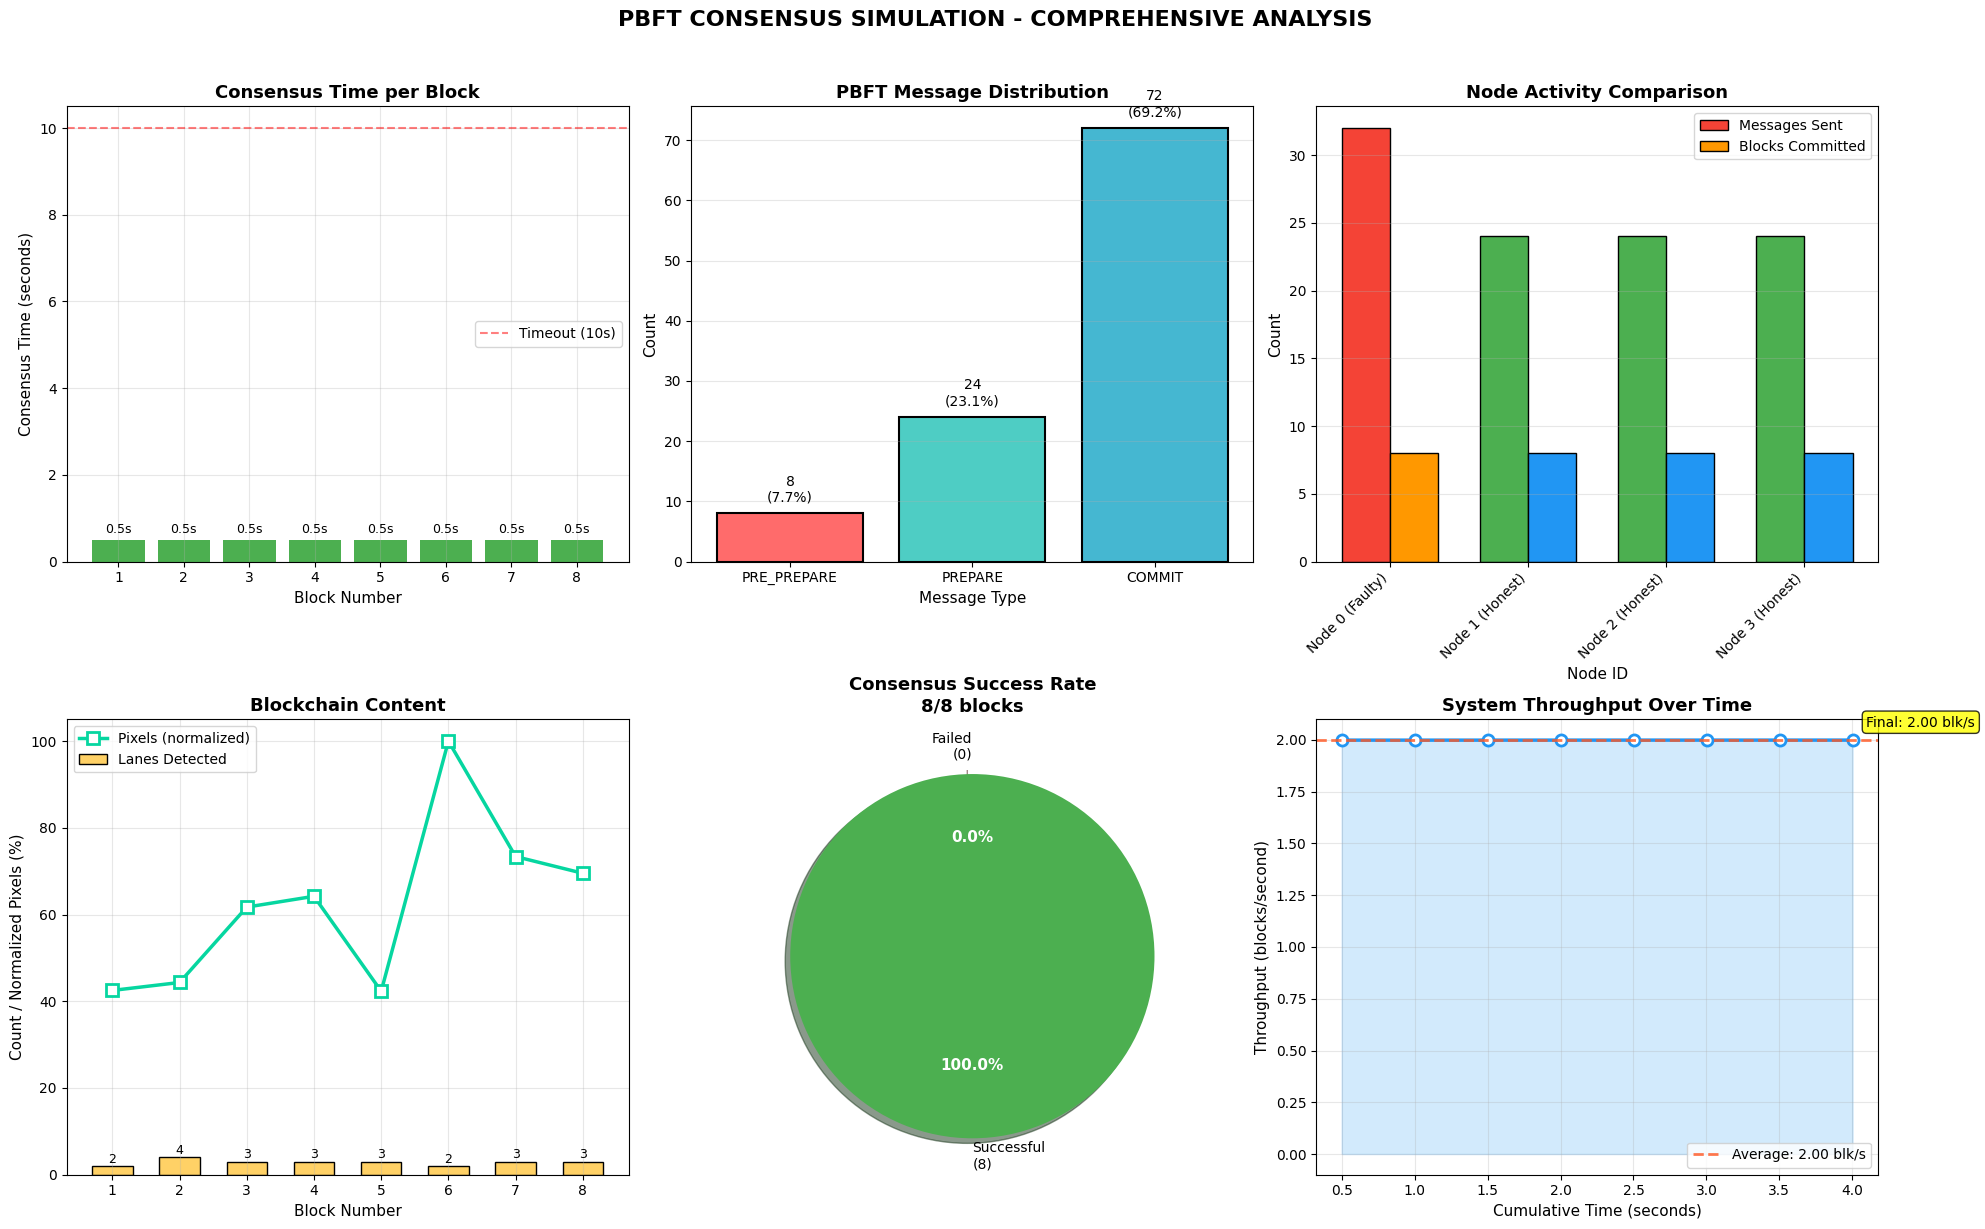


📋 Step 3: Creating detailed dashboard...

Creating detailed dashboard...


/tmp/ipykernel_55/3733644056.py:254: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/3733644056.py:257: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig('pbft_detailed_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/tmp/ipykernel_55/3733644056.py:257: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.savefig('pbft_detailed_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/tmp/ipykernel_55/3733644056.py:257: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('pbft_detailed_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/tmp/ipykernel_55/3733644056.py:257: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('pbft_detailed_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/tmp/ipykernel_55/3733644056.py:25

💾 Detailed dashboard saved as 'pbft_detailed_dashboard.png'


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPytho

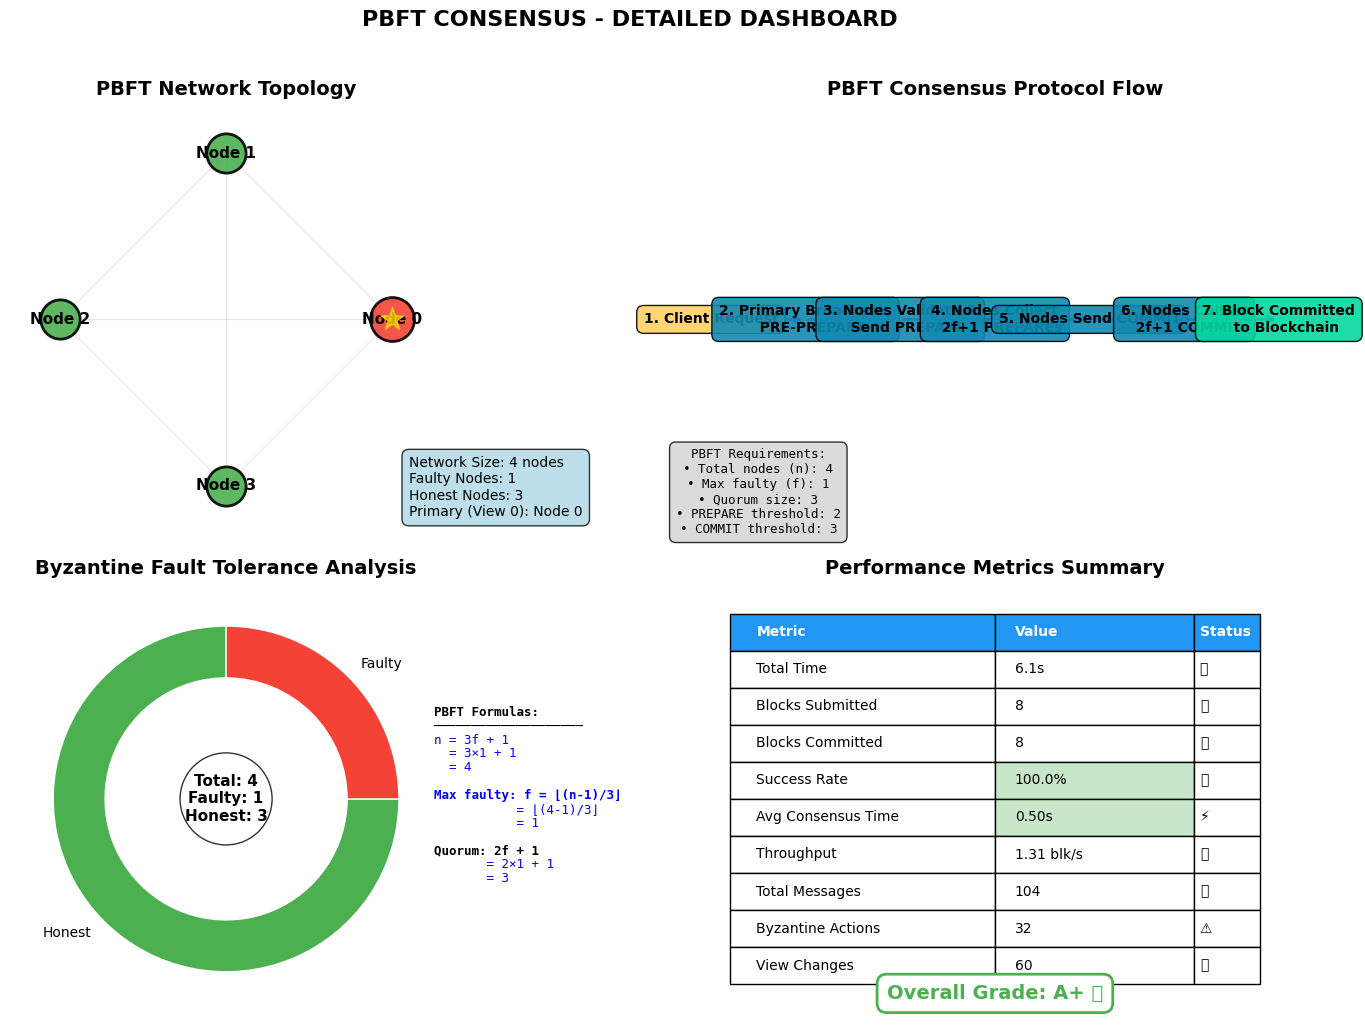


🎬 Step 4: Creating animation...

Creating block processing animation...
💾 Animation saved as 'pbft_block_processing.gif'
💾 Final status visualization saved as 'pbft_final_status.png'

✅ VISUALIZATION PIPELINE COMPLETED!

📊 FINAL METRICS:
  Total Simulation Time: 6.09 seconds
  Blocks Submitted: 8
  Blocks Committed: 8
  Success Rate: 100.0%
  Average Consensus Time: 0.50 seconds
  Total Messages: 104
  Byzantine Actions: 32
  View Changes: 60

📁 GENERATED FILES:
  1. pbft_main_visualization.png - Main 6-chart visualization
  2. pbft_detailed_dashboard.png - Detailed dashboard
  3. pbft_block_processing.gif - Animation of block processing
  4. pbft_final_status.png - Final block status
  5. pbft_static_animation.png - Static animation alternative

🎯 VISUALIZATION COMPLETE!
   Check the generated files for comprehensive PBFT analysis.

✅ Visualization pipeline executed successfully!

🎉 ALL VISUALIZATIONS READY FOR ANALYSIS!


In [72]:
# =====================================================================
# BLOCK 15E: RUN COMPLETE VISUALIZATION PIPELINE
# =====================================================================
print("\n" + "="*60)
print("🚀 RUNNING COMPLETE VISUALIZATION PIPELINE")
print("="*60)

def run_complete_visualization():
    """Run the complete visualization pipeline"""
    print("\nStarting complete visualization pipeline...")
    
    # Step 1: Run simulation with data tracking
    print("\n📊 Step 1: Running simulation with data collection...")
    nodes = run_simulation_with_tracking()
    
    # Step 2: Create main visualization
    print("\n🎨 Step 2: Creating main visualization (6 charts)...")
    create_main_visualization(nodes)
    
    # Step 3: Create detailed dashboard
    print("\n📋 Step 3: Creating detailed dashboard...")
    create_detailed_dashboard(nodes)
    
    # Step 4: Create animation
    print("\n🎬 Step 4: Creating animation...")
    create_block_processing_animation()
    
    # Step 5: Print summary
    print("\n" + "="*60)
    print("✅ VISUALIZATION PIPELINE COMPLETED!")
    print("="*60)
    
    # Calculate final metrics
    success_rate = (len(viz_metrics['committed_blocks']) / EXPECTED_BLOCKS) * 100
    avg_time = np.mean(viz_metrics['consensus_times']) if viz_metrics['consensus_times'] else 0
    total_messages = sum(viz_metrics['messages_sent'].values())
    
    print(f"\n📊 FINAL METRICS:")
    print(f"  Total Simulation Time: {viz_metrics['total_time']:.2f} seconds")
    print(f"  Blocks Submitted: {EXPECTED_BLOCKS}")
    print(f"  Blocks Committed: {len(viz_metrics['committed_blocks'])}")
    print(f"  Success Rate: {success_rate:.1f}%")
    print(f"  Average Consensus Time: {avg_time:.2f} seconds")
    print(f"  Total Messages: {total_messages}")
    print(f"  Byzantine Actions: {viz_metrics['byzantine_actions']}")
    print(f"  View Changes: {viz_metrics['view_changes']}")
    
    print(f"\n📁 GENERATED FILES:")
    print(f"  1. pbft_main_visualization.png - Main 6-chart visualization")
    print(f"  2. pbft_detailed_dashboard.png - Detailed dashboard")
    print(f"  3. pbft_block_processing.gif - Animation of block processing")
    print(f"  4. pbft_final_status.png - Final block status")
    print(f"  5. pbft_static_animation.png - Static animation alternative")
    
    print(f"\n🎯 VISUALIZATION COMPLETE!")
    print("   Check the generated files for comprehensive PBFT analysis.")
    
    return {
        'success_rate': success_rate,
        'total_time': viz_metrics['total_time'],
        'committed_blocks': len(viz_metrics['committed_blocks']),
        'metrics': viz_metrics
    }

# Run the complete visualization pipeline
print("\n🚀 Launching complete visualization pipeline...")
try:
    results = run_complete_visualization()
    print(f"\n✅ Visualization pipeline executed successfully!")
except Exception as e:
    print(f"\n❌ Error in visualization pipeline: {e}")
    print("Trying simplified visualization...")
    
    # Fallback: Create at least some visualizations
    plt.figure(figsize=(10, 6))
    plt.bar(['Submitted', 'Committed'], [EXPECTED_BLOCKS, len(viz_metrics.get('committed_blocks', []))],
           color=['blue', 'green'])
    plt.title('PBFT Consensus Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Blocks', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('pbft_simple_summary.png', dpi=150, bbox_inches='tight')
    print("💾 Created simple summary: pbft_simple_summary.png")
    plt.show()

print("\n" + "="*60)
print("🎉 ALL VISUALIZATIONS READY FOR ANALYSIS!")
print("="*60)